In [2]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from datetime import date
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import skew
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

In [4]:
def model_perform(X_train,y_train, X_test, y_test, model, name, verbose = 0 ):
    # train 
    model.fit(X_train, y_train)

    # test 
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)


    if verbose == 1 :
        print(' MAE {} '.format(mean_absolute_error(y_pred_test,y_test)))
        print(' MSE {} '.format(mean_squared_error(y_pred_test,y_test)))
        print(' R2 {} '.format(r2_score(y_train,y_pred_train)))
    else : 
        pass 
    
    result = {}
    result['mae'] = np.round(mean_absolute_error(y_pred_test,y_test),5)
    result['mse'] = np.round(mean_squared_error(y_pred_test,y_test),5)
    result['R2'] = np.round(r2_score(y_train,y_pred_train),5)
    result['name'] = name
    result['feature_size'] = X_train.shape[1]
    result['train_size'] = X_train.shape[0]
    result['test_size'] = X_test.shape[0]

    return model, y_pred_test, y_pred_train, result 

def show_error_pattern(y_pred, y_test):
    result_test = pd.DataFrame()
    result_test['score'] = y_pred
    result_test['type'] = 'predict'
    result_test['idx'] = np.arange(result_test.shape[0])

    result_test2 = pd.DataFrame()
    result_test2['score'] = np.squeeze(y_test)
    result_test2['type'] = 'test'
    result_test2['idx'] = np.arange(result_test2.shape[0])

    df_result = pd.concat([result_test2,result_test])

    sns.lineplot(data=df_result, x="idx", y='score', hue="type")


def bulk_train(df_input, drop_column, target_column, dataset_name, verbose = 0):

    error_report = []
    model_dict = {}

    # scaled the values 
    features_columns = df_input.drop(drop_column,axis=1).columns
    features_columns = list(features_columns) + [target_column]
    scaler = MinMaxScaler()
    df_input_scale = pd.DataFrame(scaler.fit_transform(df_input[features_columns]), columns = features_columns)
    
    # remove 0 rating
    df_input_scale = df_input_scale[df_input_scale['rating']>0]

    # split train and test 
    X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.12, random_state=42)

    regr = RandomForestRegressor(random_state=0)
    model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose = verbose )
    error_report.append(result_rf)

    xgbr = XGBRegressor(random_state=0)
    model_xgbr, y_pred_test_xgbr, y_pred_train_xgbr, result_xgb  = model_perform(X_train, y_train, X_test, y_test, xgbr, name='xgb', verbose = verbose)
    error_report.append(result_xgb)

    # SVR 
    svr = SVR(kernel='poly')
    model_svr, y_pred_test_svr, y_pred_train_svr, result_svr  = model_perform(X_train, y_train, X_test, y_test, svr, name='svr',verbose = verbose)
    error_report.append(result_svr)

    model_dict['rf'] = model_regr
    model_dict['xgbr'] = result_xgb
    model_dict['svr'] = result_svr
    
    df_report = pd.DataFrame(error_report)
    df_report['dataset'] = dataset_name
    return  model_dict, df_report


def bulk_train_k_fold(df_input, drop_column, target_column, dataset_name, verbose = 0):


    # scaled the values 
    features_columns = df_input.drop(drop_column,axis=1).columns
    features_columns = list(features_columns) + [target_column]
    scaler = MinMaxScaler()
    df_input_scale = pd.DataFrame(scaler.fit_transform(df_input[features_columns]), columns = features_columns)
    # remove 0 rating
    df_input_scale = df_input_scale[df_input_scale['rating'] > 0]


    scoring = ['neg_mean_absolute_error','neg_mean_squared_error','r2']


    regr = RandomForestRegressor(random_state=0)
    result_rf = cross_validation(regr, df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], scoring = scoring, cv =5 )
    df_rf = pd.DataFrame(result_rf)
    df_rf['name'] = 'rf'

    xgbr = XGBRegressor(random_state=0)
    result_xgb = cross_validation(xgbr, df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], scoring = scoring, cv =5 )
    df_xgb = pd.DataFrame(result_xgb)
    df_xgb['name'] = 'xgb'


    svr = SVR(kernel='poly')
    result_svr = cross_validation(svr, df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], scoring = scoring, cv =5 )
    df_svr = pd.DataFrame(result_svr)
    df_svr['name'] = 'svr'

    df_result = pd.concat([df_rf,df_xgb,df_svr])
    df_result['dataset'] = dataset_name

    return df_result


def cross_validation(model, X, y, scoring, cv=5):

    results = cross_validate(estimator=model,
                               X=X,
                               y=y,
                               cv=cv,
                               scoring=scoring,
                               return_train_score=True)

    return results


In [5]:
# zomato only
# df_zom = pd.read_csv('data/3_clean_zomato_feat.csv')
df_zom = pd.read_csv('data/3_jbdk_clean_zomato_feat.csv')

df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']
target_column = 'rating'

# loop = 15 
# list_report_zom = []

# for i in range(0,15):
#     model_zom, report_zom = bulk_train(df_input=df_zom, drop_column=drop_column, target_column=target_column, dataset_name='zomato_only')
#     report_zom['iteration'] = i
#     list_report_zom.append(report_zom)

# df_report_zom = pd.concat(list_report_zom).reset_index()

# cross validation 

result_zomato= bulk_train_k_fold(df_input=df_zom, drop_column=drop_column, target_column=target_column, dataset_name='zomato_only')
result_zomato['test_neg_mean_squared_error']= result_zomato['test_neg_mean_squared_error']*-1
result_zomato['test_neg_mean_absolute_error']= result_zomato['test_neg_mean_absolute_error']*-1
result_zomato['feature_size'] = len(df_zom.drop(drop_column, axis=1).columns)
result_zomato['record'] = df_zom.drop(drop_column, axis=1).shape[0]
result_zomato = result_zomato.reset_index()

In [6]:
# zomato geo 250
# df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_250.csv')
df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_250.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']
target_column = 'rating'

result_zomato_250 = bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_250')
result_zomato_250['test_neg_mean_squared_error'] = result_zomato_250['test_neg_mean_squared_error']*-1
result_zomato_250['test_neg_mean_absolute_error'] = result_zomato_250['test_neg_mean_absolute_error']*-1
result_zomato_250['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_250['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]

result_zomato_250 = result_zomato_250.reset_index()

In [7]:
# zomato geo 500
# df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_500.csv')
df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_500.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']
target_column = 'rating'

result_zomato_500 = bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_500')
result_zomato_500['test_neg_mean_squared_error'] = result_zomato_500['test_neg_mean_squared_error']*-1
result_zomato_500['test_neg_mean_absolute_error'] = result_zomato_500['test_neg_mean_absolute_error']*-1
result_zomato_500['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_500['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]

result_zomato_500 = result_zomato_500.reset_index()

In [8]:
# zomato geo 1000
# df_zom_poi = pd.read_csv('data/3_clean_zomato_gof_1000.csv')
df_zom_poi = pd.read_csv('data/3_jbdk_clean_zomato_gof_1000.csv')
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'] / 1000
df_zom_poi['rest_price_idr'] = df_zom_poi['rest_price_idr'].astype(int)

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac','geohash','encode']
target_column = 'rating'

result_zomato_1000 = bulk_train_k_fold(df_input=df_zom_poi, drop_column=drop_column, target_column=target_column, dataset_name='zomato_poi_1000')
result_zomato_1000['test_neg_mean_squared_error'] = result_zomato_1000['test_neg_mean_squared_error']*-1
result_zomato_1000['test_neg_mean_absolute_error'] = result_zomato_1000['test_neg_mean_absolute_error']*-1
result_zomato_1000['feature_size'] = len(df_zom_poi.drop(drop_column, axis=1).columns)
result_zomato_1000['record'] = df_zom_poi.drop(drop_column, axis=1).shape[0]


result_zomato_1000 = result_zomato_1000.reset_index()

In [9]:
df_total_result = pd.concat([result_zomato,result_zomato_250, result_zomato_500, result_zomato_1000])

In [10]:
today = date.today()
print("Today's date:", today)

Today's date: 2022-11-16


In [11]:
df_total_result.to_excel('data/ml_perform_crossval_raw_{}.xlsx'.format(today),index=False)

In [12]:
df_zom_poi.drop(drop_column, axis=1).columns

Index(['rest_price_idr', 'is_chain', 'rank_res_type', 'rank_fac',
       'd_1000_airport', 'd_1000_atm', 'd_1000_bank', 'd_1000_cafe',
       'd_1000_convenience_store', 'd_1000_gas_station', 'd_1000_hospital',
       'd_1000_lodging', 'd_1000_meal_takeaway', 'd_1000_mosque',
       'd_1000_park', 'd_1000_restaurant', 'd_1000_school', 'd_1000_store',
       'd_1000_supermarket', 'd_1000_train_station', 'en_1000', 'n_compt_1000',
       'avg_n_rest'],
      dtype='object')

In [16]:
df_total_result.head()

,index,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2,name,dataset,feature_size,record
0,0,1.299101,0.042175,0.086648,-0.031357,0.011333,-0.001693,-0.034148,0.819820,rf,zomato_only,4,7293
1,1,1.308649,0.032850,0.078980,-0.031101,0.009652,-0.001645,-0.026556,0.833619,rf,zomato_only,4,7293
2,2,1.376983,0.033112,0.075529,-0.030799,0.009297,-0.001617,0.080781,0.835287,rf,zomato_only,4,7293
3,3,1.467580,0.049772,0.071017,-0.031348,0.008235,-0.001678,0.001783,0.836210,rf,zomato_only,4,7293
4,4,1.295717,0.040226,0.079734,-0.031407,0.010609,-0.001701,-0.237869,0.828899,rf,zomato_only,4,7293
5,0,0.350807,0.013721,0.086275,-0.047792,0.011419,-0.003837,-0.041964,0.591561,xgb,zomato_only,4,7293
6,1,0.386518,0.000000,0.078124,-0.049231,0.009385,-0.004049,0.001931,0.590344,xgb,zomato_only,4,7293
7,2,0.341600,0.007995,0.075204,-0.048360,0.009157,-0.003909,0.094699,0.601834,xgb,zomato_only,4,7293
8,3,0.344286,0.007994,0.071207,-0.049955,0.008240,-0.004159,0.001186,0.594170,xgb,zomato_only,4,7293
9,4,0.341222,0.015991,0.079966,-0.048496,0.010817,-0.003952,-0.262181,0.602474,xgb,zomato_only,4,7293


In [13]:
df_total_result_agg = df_total_result.groupby(['name','dataset','feature_size']).agg({'test_neg_mean_absolute_error':['mean','std','median'],'test_neg_mean_squared_error':['mean','std','median']}).reset_index()
df_total_result_agg.columns = ['name','dataset','feature_size','avg_mae','std_mae','med_mae','avg_mse','std_mse','med_mse']

df_total_result_agg.to_excel('data/ml_perform_crossval_agg_{}.xlsx'.format(today),index=False)

In [14]:
df_total_result_agg

,name,dataset,feature_size,avg_mae,std_mae,med_mae,avg_mse,std_mse,med_mse
0,rf,zomato_only,4,0.078382,0.005764,0.078980,0.009825,0.001196,0.009652
1,rf,zomato_poi_1000,23,0.079267,0.005697,0.080199,0.009840,0.001229,0.009538
2,rf,zomato_poi_250,23,0.078233,0.005343,0.078591,0.009740,0.001080,0.009465
3,rf,zomato_poi_500,23,0.078615,0.005141,0.079402,0.009705,0.001076,0.009575
4,svr,zomato_only,4,0.078102,0.005887,0.078942,0.009429,0.001100,0.009306
5,svr,zomato_poi_1000,23,0.081999,0.005652,0.080520,0.010560,0.001156,0.010251
6,svr,zomato_poi_250,23,0.081775,0.006787,0.081643,0.010637,0.001695,0.010295
7,svr,zomato_poi_500,23,0.082227,0.005976,0.080493,0.010685,0.001366,0.010079
8,xgb,zomato_only,4,0.078155,0.005617,0.078124,0.009803,0.001292,0.009385
9,xgb,zomato_poi_1000,23,0.084314,0.005365,0.084941,0.011304,0.001292,0.010966


<AxesSubplot:title={'center':'Quality'}>

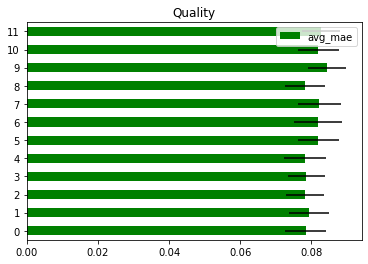

In [20]:
df_total_result_agg.plot(kind = "barh", y = "avg_mae", legend = True, xerr = "std_mae", title = "Quality", color='green')